# 1. Laboratorijska vježba

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pdb
import IPython
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn.svm as svm
import torchvision

## 1. Generiranje linearno nerazdvojivih podataka

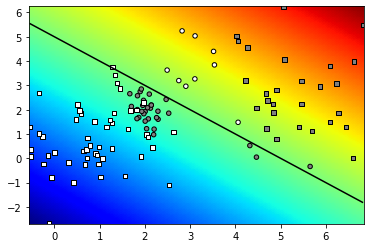

In [2]:
class Random2DGaussian:
    """Random bivariate normal distribution sampler

    Hardwired parameters:
        d0min,d0max: horizontal range for the mean
        d1min,d1max: vertical range for the mean
        scalecov: controls the covariance range

    Methods:
        __init__: creates a new distribution

        get_sample(n): samples n datapoints

    """

    d0min = 0
    d0max = 10
    d1min = 0
    d1max = 10
    scalecov = 5

    def __init__(self):
        dw0, dw1 = self.d0max - self.d0min, self.d1max - self.d1min
        mean = (self.d0min, self.d1min)
        mean += np.random.random_sample(2) * (dw0, dw1)
        eigvals = np.random.random_sample(2)
        eigvals *= (dw0 / self.scalecov, dw1 / self.scalecov)
        eigvals **= 2
        theta = np.random.random_sample() * np.pi * 2
        R = [[np.cos(theta), -np.sin(theta)],
             [np.sin(theta), np.cos(theta)]]
        Sigma = np.dot(np.dot(np.transpose(R), np.diag(eigvals)), R)
        self.get_sample = lambda n: np.random.multivariate_normal(mean, Sigma, n)


def graph_surface(function, rect, offset=0.5, width=256, height=256):
    """Creates a surface plot (visualize with plt.show)

    Arguments:
      function: surface to be plotted
      rect:     function domain provided as:
                ([x_min,y_min], [x_max,y_max])
      offset:   the level plotted as a contour plot

    Returns:
      None
    """

    lsw = np.linspace(rect[0][1], rect[1][1], width)
    lsh = np.linspace(rect[0][0], rect[1][0], height)
    xx0, xx1 = np.meshgrid(lsh, lsw)
    grid = np.stack((xx0.flatten(), xx1.flatten()), axis=1)

    # get the values and reshape them
    values = function(grid).reshape((width, height))

    # fix the range and offset
    delta = offset if offset else 0
    maxval = max(np.max(values) - delta, - (np.min(values) - delta))

    # draw the surface and the offset
    plt.pcolormesh(xx0, xx1, values, vmin=delta - maxval, vmax=delta + maxval, shading='auto', cmap='jet')

    if offset != None:
        plt.contour(xx0, xx1, values, colors='black', levels=[offset])


def graph_data(X, Y_, Y, special=[]):
    """Creates a scatter plot (visualize with plt.show)

    Arguments:
        X:       datapoints
        Y_:      groundtruth classification indices
        Y:       predicted class indices
        special: use this to emphasize some points

    Returns:
        None
    """
    # colors of the datapoint markers
    palette = ([0.5, 0.5, 0.5], [1, 1, 1], [0.2, 0.2, 0.2])
    colors = np.tile([0.0, 0.0, 0.0], (Y_.shape[0], 1))
    for i in range(len(palette)):
        colors[Y_ == i] = palette[i]

    # sizes of the datapoint markers
    sizes = np.repeat(20, len(Y_))
    sizes[special] = 40

    # draw the correctly classified datapoints
    good = (Y_ == Y)
    plt.scatter(X[good, 0], X[good, 1], c=colors[good],
                s=sizes[good], marker='o', edgecolors="black")

    # draw the incorrectly classified datapoints
    bad = (Y_ != Y)
    plt.scatter(X[bad, 0], X[bad, 1], c=colors[bad],
                s=sizes[bad], marker='s', edgecolors="black")


def class_to_onehot(Y):
    Yoh = np.zeros((len(Y), max(Y) + 1))
    Yoh[range(len(Y)), Y] = 1
    return Yoh


def eval_perf_binary(Y, Y_):
    tp = sum(np.logical_and(Y == Y_, Y_ == True))
    fn = sum(np.logical_and(Y != Y_, Y_ == True))
    tn = sum(np.logical_and(Y == Y_, Y_ == False))
    fp = sum(np.logical_and(Y != Y_, Y_ == False))
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fn + tn + fp)
    return accuracy, recall, precision


def eval_perf_multi(Y, Y_):
    pr = []
    n = max(Y_) + 1
    M = np.bincount(n * Y_ + Y, minlength=n * n).reshape(n, n)
    for i in range(n):
        tp_i = M[i, i]
        fn_i = np.sum(M[i, :]) - tp_i
        fp_i = np.sum(M[:, i]) - tp_i
        tn_i = np.sum(M) - fp_i - fn_i - tp_i
        recall_i = tp_i / (tp_i + fn_i)
        precision_i = tp_i / (tp_i + fp_i)
        pr.append((recall_i, precision_i))

    accuracy = np.trace(M) / np.sum(M)

    return accuracy, pr, M


def eval_AP(ranked_labels):
    """Recovers AP from ranked labels"""

    n = len(ranked_labels)
    pos = sum(ranked_labels)
    neg = n - pos

    tp = pos
    tn = 0
    fn = 0
    fp = neg

    sumprec = 0
    # IPython.embed()
    for x in ranked_labels:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        if x:
            sumprec += precision

        # print (x, tp,tn,fp,fn, precision, recall, sumprec)
        # IPython.embed()

        tp -= x
        fn += x
        fp -= not x
        tn += not x

    return sumprec / pos


def sample_gauss_2d(nclasses, nsamples):
    # create the distributions and groundtruth labels
    Gs = []
    Ys = []
    for i in range(nclasses):
        Gs.append(Random2DGaussian())
        Ys.append(i)

    # sample the dataset
    X = np.vstack([G.get_sample(nsamples) for G in Gs])
    Y_ = np.hstack([[Y] * nsamples for Y in Ys])

    return X, Y_


def sample_gmm_2d(ncomponents, nclasses, nsamples):
    # create the distributions and groundtruth labels
    Gs = []
    Ys = []
    for i in range(ncomponents):
        Gs.append(Random2DGaussian())
        Ys.append(np.random.randint(nclasses))

    # sample the dataset
    X = np.vstack([G.get_sample(nsamples) for G in Gs])
    Y_ = np.hstack([[Y] * nsamples for Y in Ys])

    return X, Y_


def myDummyDecision(X):
    scores = X[:, 0] + X[:, 1] - 5
    return scores


if __name__ == "__main__":
    np.random.seed(100)

    # get data
    X, Y_ = sample_gmm_2d(4, 2, 30)
    # X,Y_ = sample_gauss_2d(2, 100)

    # get the class predictions
    Y = myDummyDecision(X) > 0.5

    # graph the decision surface
    rect = (np.min(X, axis=0), np.max(X, axis=0))
    graph_surface(myDummyDecision, rect, offset=0)

    # graph the data points
    graph_data(X, Y_, Y, special=[])

    plt.show()


## 2. Višeslojna klasifikacija u Pythonu

0.8333333333333334 0.6666666666666666 1.0


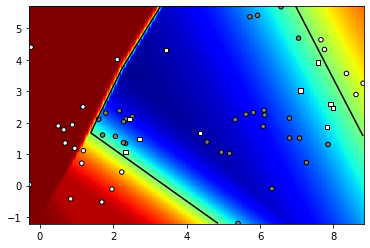

In [4]:
param_niter = 100000
param_delta = 0.05
param_lambda = 0.0001


def ReLu(x):
    return np.maximum(0, x)


def softmax(x):
    exps2 = np.exp(x)
    sumexp = np.sum(exps2, axis=1)
    return exps2 / sumexp[:, None]


def calculate_loss(Y_, probs):
    correct_y = probs[np.arange(len(probs)), Y_.argmax(axis=1)]
    return -np.mean(np.log(correct_y))


def fcann2_train(X, Y_, hidden, print_bool=False):
    N = len(X)
    C = len(Y_[0])
    D = len(X[0])

    W1 = np.random.randn(D, hidden)
    b1 = np.zeros((1, hidden))
    W2 = np.random.randn(hidden, C)
    b2 = np.zeros((1, C))

    for i in range(param_niter):
        s1 = np.matmul(X, W1) + b1
        h1 = ReLu(s1)
        s2 = np.matmul(h1, W2) + b2
        probs = softmax(s2)

        loss = calculate_loss(Y_, probs)
        squared_weight_parts = np.linalg.norm(W1)**2+np.linalg.norm(W2)**2
        loss += param_lambda * squared_weight_parts

        G_s2 = probs
        G_s2[np.arange(len(probs)), np.argmax(Y_, axis=1)] -= 1
        G_s2 = G_s2 / N

        # dijagnostički ispis
        if i % 10 == 0 and print_bool:
            print("iteration {}: loss {}".format(i, loss))

        grad_W2 = np.matmul(np.transpose(h1), G_s2)  # CxH
        grad_b2 = np.transpose(np.sum(G_s2, axis=0))  # Cx1

        G_s1 = np.matmul(G_s2, np.transpose(W2))
        G_s1[h1 <= float(0)] = 0

        grad_W1 = np.matmul(np.transpose(X), G_s1)
        grad_b1 = np.transpose(np.sum(G_s1, axis=0))
        
        W1 += -param_delta * grad_W1
        b1 += -param_delta * grad_b1
        W2 += -param_delta * grad_W2
        b2 += -param_delta * grad_b2

    return W1, b1, W2, b2


def fcann2_classify(X, W1, b1, W2, b2):
    s1 = np.matmul(X, W1) + b1
    h1 = ReLu(s1)
    s2 = np.matmul(h1, W2) + b2
    return softmax(s2)


def fcann2_decfun(W1, b1, W2, b2):
    def classify(X):
        probs = fcann2_classify(X, W1, b1, W2, b2)
        return probs[:, 1]

    return classify


if __name__ == "__main__":
    np.random.seed(100)

    # get the training dataset
    X, Y_ = sample_gmm_2d(6, 2, 10)

    # train the model
    w1, b1, w2, b2 = fcann2_train(X, class_to_onehot(Y_), 5)

    # evaluate the model on the training dataset
    probs = fcann2_classify(X, w1, b1, w2, b2)
    Y = np.array([np.argmax(row) for row in probs])

    # report performance
    accuracy, recall, precision = eval_perf_binary(Y, Y_)

    print(accuracy, recall, precision)

    # graph the decision surface
    decfun = fcann2_decfun(w1, b1, w2, b2)
    bbox = (np.min(X, axis=0), np.max(X, axis=0))
    graph_surface(decfun, bbox, offset=0.5)

    # graph the data points
    graph_data(X, Y_, Y, special=[])
    plt.show()


## 3. Linearna regresija u PyTorchu

grad torch: tensor([-21.6001]), tensor([-9.1264])
grad calc: -21.600053787231445, -9.126396179199219
step: 0, loss:25.524335861206055, Y_:tensor([0.4472, 0.4368, 0.4264], grad_fn=<AddBackward0>), a:tensor([2.1496], requires_grad=True), b tensor([1.3703], requires_grad=True)
grad torch: tensor([2.2106]), tensor([1.3389])
grad calc: 2.2105581760406494, 1.3389054536819458
step: 1, loss:1.0300389528274536, Y_:tensor([3.5199, 5.6695, 7.8190], grad_fn=<AddBackward0>), a:tensor([1.9285], requires_grad=True), b tensor([1.2364], requires_grad=True)
grad torch: tensor([-0.3882]), tensor([0.1869])
grad calc: -0.3881928026676178, 0.1869007796049118
step: 2, loss:0.7264714241027832, Y_:tensor([3.1649, 5.0935, 7.0220], grad_fn=<AddBackward0>), a:tensor([1.9673], requires_grad=True), b tensor([1.2178], requires_grad=True)
grad torch: tensor([-0.1006]), tensor([0.3048])
grad calc: -0.10063966363668442, 0.30479779839515686
step: 3, loss:0.7123883962631226, Y_:tensor([3.1851, 5.1524, 7.1197], grad_fn=<A

grad calc: -0.03374512866139412, 0.0767119750380516
step: 58, loss:0.5146081447601318, Y_:tensor([2.6787, 5.0384, 7.3980], grad_fn=<AddBackward0>), a:tensor([2.3630], requires_grad=True), b tensor([0.3114], requires_grad=True)
grad torch: tensor([-0.0329]), tensor([0.0749])
grad calc: -0.03293387219309807, 0.07486788183450699
step: 59, loss:0.5139145255088806, Y_:tensor([2.6744, 5.0374, 7.4004], grad_fn=<AddBackward0>), a:tensor([2.3663], requires_grad=True), b tensor([0.3040], requires_grad=True)
grad torch: tensor([-0.0321]), tensor([0.0731])
grad calc: -0.03214327618479729, 0.07306766510009766
step: 60, loss:0.5132534503936768, Y_:tensor([2.6702, 5.0365, 7.4028], grad_fn=<AddBackward0>), a:tensor([2.3695], requires_grad=True), b tensor([0.2966], requires_grad=True)
grad torch: tensor([-0.0314]), tensor([0.0713])
grad calc: -0.03137063980102539, 0.07131115347146988
step: 61, loss:0.5126238465309143, Y_:tensor([2.6662, 5.0357, 7.4052], grad_fn=<AddBackward0>), a:tensor([2.3726], requi

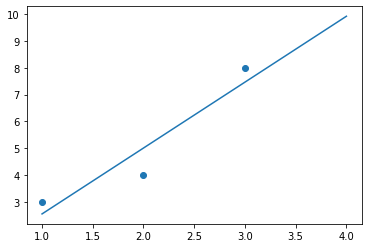

In [5]:
## Definicija računskog grafa
# podaci i parametri, inicijalizacija parametara
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

X = torch.tensor([1, 2, 3])
Y = torch.tensor([3, 4, 8])

# optimizacijski postupak: gradijentni spust
optimizer = optim.SGD([a, b], lr=0.1)


def gradient(a, b):
    N = len(X)
    b_grad = 2 * (a * X + b - Y)
    a_grad = b_grad * X
    b_grad = torch.sum(b_grad) / N
    a_grad = torch.sum(a_grad) / N
    return a_grad, b_grad


for i in range(100):
    # afin regresijski model
    Y_ = a * X + b

    diff = (Y - Y_)

    # kvadratni gubitak
    loss = 1 / len(X) * torch.sum(diff ** 2)

    # računanje gradijenata
    loss.backward()

    print(f'grad torch: {a.grad}, {b.grad}')
    a_grad, b_grad = gradient(a, b)
    print(f'grad calc: {a_grad}, {b_grad}')

    # korak optimizacije
    optimizer.step()

    # Postavljanje gradijenata na nulu
    optimizer.zero_grad()

    print(f'step: {i}, loss:{loss}, Y_:{Y_}, a:{a}, b {b}')

plt.scatter(X.numpy(), Y.numpy())
linspace = np.linspace(1, 4)
plt.plot(linspace, a.detach().numpy() * linspace + b.detach().numpy())
plt.show()

Modifikacija za proizvoljan broj točaka:
```
loss = 1 / len(X) * torch.sum(diff ** 2)
```

Analitičke vrijednosti za gradijente dobivene su na sljedeći način. Isprve razmatramo slučaj kada imamo stohastički gradijentni spust. Tada funkcija gubitka izgleda:

$$ L(a,b|X,y) = (a*X + b - y)^2$$

Definiramo pomoćnu varijablu $s$ koja predstavlja izlaz modela

$$s = a*X + b$$

Sada uz pravilo ulančavanja možemo dobiti gradijente za svaki parametar

$$ \frac{\partial L }{\partial a} = \frac{\partial L}{\partial s} \frac{\partial s}{\partial a} = 2(s-y)*x$$
$$ \frac{\partial L }{\partial b} = \frac{\partial L}{\partial s} \frac{\partial s}{\partial b} = 2(s-y)$$

Za ovaj slučaj, kako bi dobili pravi gradijent, samo trebamo posumirati i podijeliti s brojem podataka.


$$ \frac{\partial L }{\partial a} = \frac{\partial L}{\partial s} \frac{\partial s}{\partial a} = \frac{1}{N} \sum_{i=0}^N 2(a\cdot x_i+b-y_i)\cdot x_i$$
$$ \frac{\partial L }{\partial b} = \frac{\partial L}{\partial s} \frac{\partial s}{\partial b} = \frac{1}{N} \sum_{i=0}^N 2(a\cdot x_i+b-y_i)$$


## 4. Logistička regresija u PyTorchu


Performance: acc=0.7625, pr=[(0.5, 0.6666666666666666), (0.825, 0.75), (0.9, 0.8571428571428571)],
 M=[[10  9  1]
 [ 5 33  2]
 [ 0  2 18]]


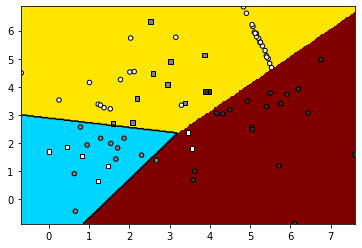

In [8]:
class PTLogreg(nn.Module):
    def __init__(self, D, C):
        """Arguments:
           - D: dimensions of each datapoint
           - C: number of classes
        """
        super().__init__()
        self.W = nn.Parameter(torch.randn((D, C)), requires_grad=True)
        self.b = nn.Parameter(torch.zeros((C)), requires_grad=True)

    def forward(self, X):
        s = X.mm(self.W) + self.b
        out = torch.softmax(s, dim=1)
        return out

    def get_loss(self, X, Yoh_):
        out = self.forward(X)
        correct_y = out[np.arange(len(out)), Yoh_.argmax(axis=1)]
        log_out = torch.log(correct_y)
        loss = -torch.mean(log_out)
        return loss


def train(model, X, Yoh_, param_niter, param_delta, param_lambda, print_bool=False):
    """Arguments:
       - X: model inputs [NxD], type: torch.Tensor
       - Yoh_: ground truth [NxC], type: torch.Tensor
       - param_niter: number of training iterations
       - param_delta: learning rate
    """
    optimizer = optim.SGD(params=model.parameters(), lr=param_delta)

    for i in range(param_niter):
        loss = model.get_loss(X, Yoh_) + param_lambda/2 * torch.norm(model.W)**2
        loss.backward()
        optimizer.step()

        if print_bool:
            print(f'step: {i}, loss:{loss}, W:{model.W}, b {model.b}')

        optimizer.zero_grad()


def eval(model, X):
    """Arguments:
       - model: type: PTLogreg
       - X: actual datapoints [NxD], type: np.array
       Returns: predicted class probabilites [NxC], type: np.array
    """
    return model.forward(torch.tensor(X, dtype=torch.float)).detach().numpy()


def logreg_decfun(model):
    def classify(X):
        return np.argmax(eval(model, X), axis=1)

    return classify


if __name__ == "__main__":
    # inicijaliziraj generatore slučajnih brojeva
    np.random.seed(100)

    # instanciraj podatke X i labele Yoh_
    x, Y_ = sample_gmm_2d(4, 3, 20)
    X = torch.tensor(x, dtype=torch.float)
    Yoh_ = torch.tensor(class_to_onehot(Y_), dtype=torch.float)

    # definiraj model:
    ptlr = PTLogreg(X.shape[1], Yoh_.shape[1])

    # nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
    train(ptlr, X, Yoh_, 1000, 0.1, 0)

    # dohvati vjerojatnosti na skupu za učenje
    probs = eval(ptlr, x)
    Y = np.argmax(probs, axis=1)
    Y_logreg = Y

    # ispiši performansu (preciznost i odziv po razredima)
    accuracy, pr, M = eval_perf_multi(Y, Y_)
    print()
    print(f"Performance: acc={accuracy}, pr={pr},\n M={M}")

    # iscrtaj rezultate, decizijsku plohu
    decfun = logreg_decfun(ptlr)
    bbox = (np.min(x, axis=0), np.max(x, axis=0))
    graph_surface(decfun, bbox, offset=0.5)

    # graph the data points
    graph_data(x, Y_, Y, special=[])
    plt.show()


Gubitak ne ovisi o broju podataka za učenje jer je uzeta aritmetička sredina pojedinih gubitaka
```
out = self.forward(X)
correct_y = out[np.arange(len(out)), Yoh_.argmax(axis=1)]
log_out = torch.log(correct_y)
loss = -torch.mean(log_out)
```

Regularizacija je ostvarena na sljedeći način
```
loss = model.get_loss(X, Yoh_) + param_lambda * torch.norm(model.W)
```

U nastavku je prikazan utjecaj regularizacije s `param_lambda = 0.1`
Možemo vidjeti da je u tom slučaju nagib same granice oštriji te pomak veći. Regularizacija utječe na način da kažnjava modele s većim parametrima, radi pretpostavke da su takvi modeli prenaučeni.


Performance: acc=0.775, pr=[(0.55, 0.6875), (0.825, 0.75), (0.9, 0.9)],
 M=[[11  9  0]
 [ 5 33  2]
 [ 0  2 18]]


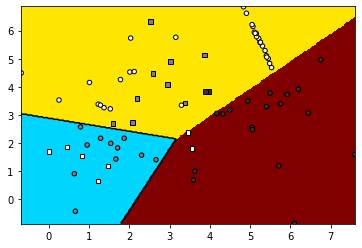

In [9]:
if __name__ == "__main__":
    # inicijaliziraj generatore slučajnih brojeva
    np.random.seed(100)

    # instanciraj podatke X i labele Yoh_
    x, Y_ = sample_gmm_2d(4, 3, 20)
    X = torch.tensor(x, dtype=torch.float)
    Yoh_ = torch.tensor(class_to_onehot(Y_), dtype=torch.float)

    # definiraj model:
    ptlr = PTLogreg(X.shape[1], Yoh_.shape[1])

    # nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
    train(ptlr, X, Yoh_, 1000, 0.1, 0.1)

    # dohvati vjerojatnosti na skupu za učenje
    probs = eval(ptlr, x)
    Y = np.argmax(probs, axis=1)

    # ispiši performansu (preciznost i odziv po razredima)
    accuracy, pr, M = eval_perf_multi(Y, Y_)
    print()
    print(f"Performance: acc={accuracy}, pr={pr},\n M={M}")

    # iscrtaj rezultate, decizijsku plohu
    decfun = logreg_decfun(ptlr)
    bbox = (np.min(x, axis=0), np.max(x, axis=0))
    graph_surface(decfun, bbox, offset=0.5)

    # graph the data points
    graph_data(x, Y_, Y, special=[])
    plt.show()


## 5. Konfigurabilni duboki modeli u PyTorchu


Performance: acc=0.7625, pr=[(0.5, 0.6666666666666666), (0.825, 0.75), (0.9, 0.8571428571428571)],
 M=[[10  9  1]
 [ 5 33  2]
 [ 0  2 18]]
Parameters: 
    name: weights.0, dimension: torch.Size([2, 3]) 
    name: biases.0, dimension: torch.Size([1, 3]) 
    total number of parameters: 9


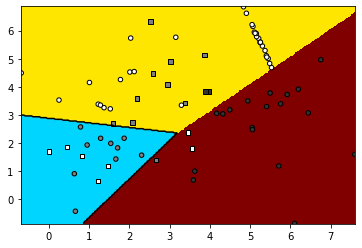

In [10]:
class PTDeep(nn.Module):
    def __init__(self, layers: [], activation_function):
        """Arguments:
           - layers: dimensions of each layer
           - activation_function: activation function of hidden layers
        """
        super().__init__()
        weights = []
        biases = []

        for i in range(0, len(layers) - 1, 1):
            Wi = nn.Parameter(torch.randn((layers[i], layers[i + 1])), requires_grad=True)
            bi = nn.Parameter(torch.zeros((1, layers[i + 1])), requires_grad=True)
            weights.append(Wi)
            biases.append(bi)

        self.activation_function = activation_function
        self.weights = nn.ParameterList(weights)
        self.biases = nn.ParameterList(biases)

    def forward(self, X):
        s = X
        for wi, bi in zip(self.weights, self.biases):
            s = X.mm(wi) + bi
            X = self.activation_function(s)

        out = torch.softmax(s, dim=1)
        return out

    def get_loss(self, X, Yoh_):
        out = self.forward(X)
        correct_y = out[np.arange(len(out)), Yoh_.argmax(axis=1)]
        log_out = torch.log(correct_y)
        loss = -torch.mean(log_out)
        return loss


def train(model, X, Yoh_, param_niter, param_delta, param_lambda, print_bool=True):
    """Arguments:
       - X: model inputs [NxD], type: torch.Tensor
       - Yoh_: ground truth [NxC], type: torch.Tensor
       - param_niter: number of training iterations
       - param_delta: learning rate
    """
    optimizer = optim.SGD(params=model.parameters(), lr=param_delta)

    for i in range(param_niter):
        loss = model.get_loss(X, Yoh_) + param_lambda * torch.sum(
            torch.tensor([torch.norm(wi) ** 2 for wi in model.weights]))
        loss.backward()
        optimizer.step()

        if print_bool:
            print(f'step: {i}, loss:{loss}, W:{model.weights}, b {model.biases}')

        optimizer.zero_grad()


def eval(model, X):
    """Arguments:
       - model: type: PTLogreg
       - X: actual datapoints [NxD], type: np.array
       Returns: predicted class probabilites [NxC], type: np.array
    """
    return model.forward(torch.tensor(X, dtype=torch.float)).detach().numpy()


def count_params(model: nn.Module):
    count = 0
    print("Parameters: ")
    for param in model.named_parameters():
        print(f'    name: {param[0]}, dimension: {param[1].shape} ')
        count += len(param[1]) * len(param[1][0])
    print(f'    total number of parameters: {count}')


def deep_decfun(model):
    def classify(X):
        return eval(model, X)[:, 1]

    return classify


if __name__ == "__main__":
    # inicijaliziraj generatore slučajnih brojeva
    np.random.seed(100)

    # instanciraj podatke X i labele Yoh_
    x, Y_ = sample_gmm_2d(4, 3, 20)
    X = torch.tensor(x, dtype=torch.float)
    Yoh_ = torch.tensor(class_to_onehot(Y_), dtype=torch.float)

    # definiraj model:
    ptd = PTDeep([2, 3], torch.relu)

    # nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
    train(ptd, X, Yoh_, 1000, 0.1, 0, False)

    # dohvati vjerojatnosti na skupu za učenje
    probs = eval(ptd, x)
    Y = np.argmax(probs, axis=1)
    Y_deep = Y

    # ispiši performansu (preciznost i odziv po razredima)
    accuracy, pr, M = eval_perf_multi(Y, Y_)
    print()
    print(f"Performance: acc={accuracy}, pr={pr},\n M={M}")
    count_params(ptd)

    # iscrtaj rezultate, decizijsku plohu
    decfun = deep_decfun(ptd)
    bbox = (np.min(x, axis=0), np.max(x, axis=0))
    graph_surface(lambda x: np.argmax(eval(ptd, x), axis=1), bbox, offset=0.5)

    # graph the data points
    graph_data(x, Y_, Y, special=[])
    plt.show()


Provjera jesu li rezultati isti:

In [11]:
print(Y_deep == Y_logreg)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


Kod na podatcima dobivenim pozivima data.sample_gmm_2d(4, 2, 40) i data.sample_gmm_2d(6, 2, 10), za konfiguracije [2, 2], [2, 10, 2] i [2, 10, 10, 2]. 

In [12]:
def helper_funct(n_components, n_classes, n_samples, config, function):
    np.random.seed(100)

    x, Y_ = sample_gmm_2d(n_components, n_classes, n_samples)
    X = torch.tensor(x, dtype=torch.float)
    Yoh_ = torch.tensor(class_to_onehot(Y_), dtype=torch.float)

    ptd = PTDeep(config, function)
    train(ptd, X, Yoh_, 10000, 0.1, 0.0001, print_bool=False)

    probs = eval(ptd, x)
    Y = np.argmax(probs, axis=1)

    accuracy, recall, precision = eval_perf_binary(Y, Y_)
    ap = eval_AP(Y_[probs[:, 1].argsort()])
    print()
    print(f"Performance: acc={accuracy}, r={recall}, p={precision}, ap={ap}")

    decfun = deep_decfun(ptd)
    bbox = (np.min(x, axis=0), np.max(x, axis=0))
    graph_surface(lambda x: eval(ptd, x)[:, 1], bbox, offset=0.5)
    graph_data(x, Y_, Y, special=[])
    plt.show()


Performance: acc=0.675, r=0.7625, p=0.648936170212766, ap=0.8896670865230665


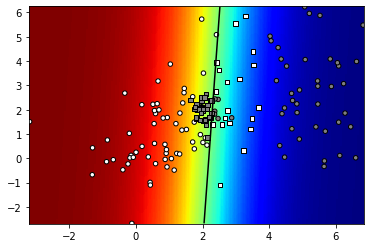


Performance: acc=0.89375, r=0.8125, p=0.9701492537313433, ap=0.9445485343082602


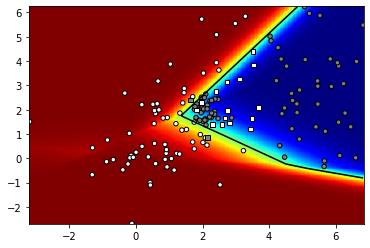


Performance: acc=0.95625, r=0.95, p=0.9620253164556962, ap=0.9925624092243716


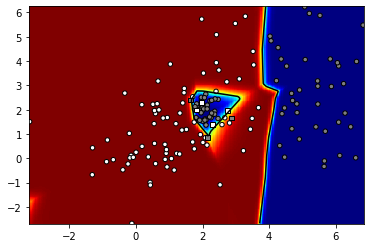

In [20]:
helper_funct(4, 2, 40, [2, 2], torch.relu)
helper_funct(4, 2, 40, [2, 10, 2], torch.relu)
helper_funct(4, 2, 40, [2, 10, 10, 2], torch.relu)


Performance: acc=0.6, r=0.6333333333333333, p=0.59375, ap=0.7127613412011518


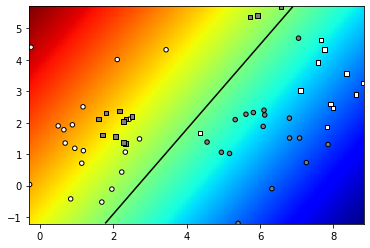


Performance: acc=0.8166666666666667, r=0.7, p=0.9130434782608695, ap=0.9253095061341658


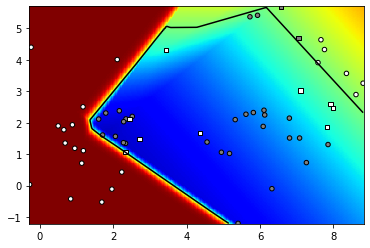


Performance: acc=0.85, r=0.9666666666666667, p=0.7837837837837838, ap=0.9036380550223323


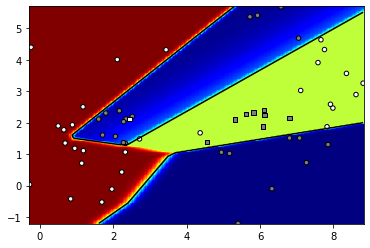

In [21]:
helper_funct(6, 2, 10, [2, 2], torch.relu)
helper_funct(6, 2, 10, [2, 10, 2], torch.relu)
helper_funct(6, 2, 10, [2, 10, 10, 2], torch.relu)


Performance: acc=0.6, r=0.6333333333333333, p=0.59375, ap=0.7127613412011518


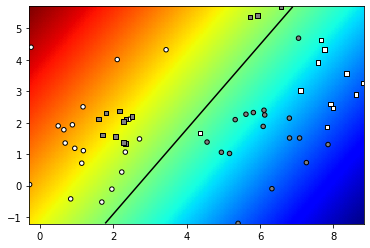


Performance: acc=0.95, r=0.9, p=1.0, ap=0.9822346282732037


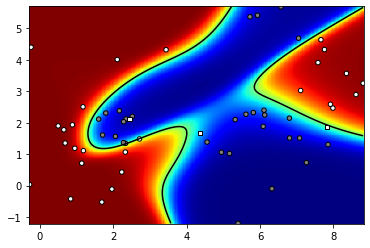


Performance: acc=0.9833333333333333, r=0.9666666666666667, p=1.0, ap=0.9884057971014493


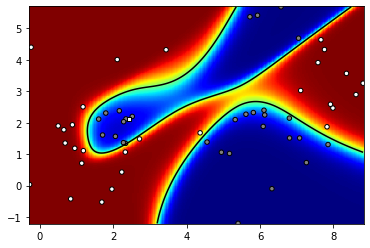

In [12]:
helper_funct(6, 2, 10, [2, 2], torch.sigmoid)
helper_funct(6, 2, 10, [2, 10, 2], torch.sigmoid)
helper_funct(6, 2, 10, [2, 10, 10, 2], torch.sigmoid)

## 6. Usporedba s jezgrenim SVM-om


Performance: acc=0.9333333333333333, p=0.8666666666666667, r=1.0, ap=0.980694746072944


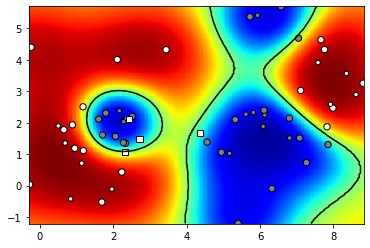

In [15]:
class KSVMWrap():
    def __init__(self, X, Y_, param_svm_c=1, param_svm_gamma='auto'):
        """Konstruira omotač i uči RBF SVM klasifikator
        X, Y_:           podatci i točni indeksi razreda
        param_svm_c:     relativni značaj podatkovne cijene
        param_svm_gamma: širina RBF jezgre"""
        super().__init__()
        self.model = svm.SVC(C=param_svm_c, gamma=param_svm_gamma, kernel='rbf', probability=True)
        self.model.fit(X, Y_)

    def predict(self, X):
        """Predviđa i vraća indekse razreda podataka X"""
        return self.model.predict(X)

    def get_scores(self, X):
        """Vraća klasifikacijske mjere
        (engl. classification scores) podataka X;
        ovo će vam trebati za računanje prosječne preciznosti."""
        return self.model.predict_proba(X)

    def support(self):
        """Indeksi podataka koji su odabrani za potporne vektore"""
        return self.model.support_


if __name__ == "__main__":
    np.random.seed(100)

    X, Y_ = sample_gmm_2d(6, 2, 10)
    ksvm = KSVMWrap(X, Y_)

    probs = ksvm.get_scores(X)
    Y = ksvm.predict(X)

    acc, p, r = eval_perf_binary(Y, Y_)
    ap = eval_AP(Y_[probs[:, 1].argsort()])
    print()
    print(f"Performance: acc={acc}, p={p}, r={r}, ap={ap}")

    # decfun = deep_decfun(ptd)
    bbox = (np.min(X, axis=0), np.max(X, axis=0))
    graph_surface(lambda x: ksvm.get_scores(x)[:, 1], bbox, offset=0.5)

    # graph the data points
    graph_data(X, Y_, Y, special=ksvm.support())
    plt.show()

Usporedba performansi modela koje implementiraju razredi PTDeep i KSVMWrap na većem broju slučajnih skupova podataka:

In [16]:
np.random.seed(100)

X, Y_ = sample_gmm_2d(4, 2, 40)
X_torch = torch.tensor(X, dtype=torch.float)
Yoh_ = torch.tensor(class_to_onehot(Y_), dtype=torch.float)

ptd = PTDeep([2, 10, 10, 2], torch.relu)
train(ptd, X_torch, Yoh_, 10000, 0.1, 0.0001, print_bool=False)
ksvm = KSVMWrap(X, Y_)

probs = ksvm.get_scores(X)
Y = ksvm.predict(X)

accuracy, recall, precision = eval_perf_binary(Y, Y_)
ap = eval_AP(Y_[probs[:, 1].argsort()])
print()
print(f"Performance KSVM: acc={accuracy}, r={recall}, p={precision}, ap={ap}")

probs = eval(ptd, X)
Y = np.argmax(probs, axis=1)

accuracy, recall, precision = eval_perf_binary(Y, Y_)
ap = eval_AP(Y_[probs[:, 1].argsort()])
print()
print(f"Performance DEEP: acc={accuracy}, r={recall}, p={precision}, ap={ap}")


Performance KSVM: acc=0.925, r=0.875, p=0.9722222222222222, ap=0.9867556814563565

Performance DEEP: acc=0.90625, r=0.85, p=0.9577464788732394, ap=0.977111780487656


**Q** Koje su prednosti i nedostatci njihovih funkcija gubitka?

**A** Funkcija gubitka našeg dubokog morela je prosjek negativne log-izglednost modela preko svih podataka. Prednosti takve funkcije gubitka su probabilistička interpretacija i jednostavna višeklasna klasifikacija. Pod probabilističkom interpretacijom mislimo na to da je jedna od pretpostavki da podaci pripadaju nekoj klasi s određenom vjerojatnošću. Nedostatak je računalna složenost. Kod SVM-a funkcija gubitka zove se gubitak zglobnice. Prednosti gubitka zglobnice su što je konveksne gornje mede funkcije gubitka 0-1 te što kažnjava modele koji jesu točni, ali nisu jako sigurni u svoju klasifikaciju (zbog postojanja margine). Uz to, moguće je napraviti jezgreni trik. Nedostatak je da funkcija nije diferencijabilna u primarnoj formi. 


**Q** Koji od dvaju postupaka daje bolju garantiranu performansu? 

**A** Duboki modeli mogu, ali i ne moraju pronaći zadovoljavajuće rješenje. Iz tog razloga bolju garantiranu performansu daje SVM.


**Q** Koji od postupaka može primiti veći broj parametara? 

**A** Duboki modeli mogu primiti veći broj parametara.


**Q** Koji bi od postupaka bio prikladniji za 2D podatke uzorkovane iz mješavine Gaussovih distribucija?

**A** Kako su podaci uzorkovani iz mješavine Gaussovih distribucija, prikladniji postupak bio bi SVM sa radijalnim jezgrama. Ako imamo predznanje o središtima grupa to bi također mogli iskoristiti kao središta radijalnih funkcija.

## 7. Studija slučaja: MNIST

In [43]:
dataset_root = '/tmp/mnist'  # change this to your preference
mnist_train = torchvision.datasets.MNIST(dataset_root, train=True, download=True)
mnist_test = torchvision.datasets.MNIST(dataset_root, train=False, download=True)

x_train, y_train = mnist_train.data, mnist_train.targets
x_test, y_test = mnist_test.data, mnist_test.targets
x_train, x_test = x_train.float().div_(255.0), x_test.float().div_(255.0)

N = x_train.shape[0]
D = x_train.shape[1] * x_train.shape[2]
C = y_train.max().add_(1).item()

x_train = x_train.reshape((N, D))
x_test = x_test.reshape((len(x_test), D))

def train(model, X, Yoh_, param_niter, param_delta, param_lambda, print_bool=False):
    optimizer = optim.SGD(params=model.parameters(), lr=param_delta)
    losses = []

    for i in range(param_niter):
        loss = model.get_loss(X, Yoh_)
        loss += param_lambda / 2 * torch.mean(torch.tensor([torch.norm(wi) ** 2 for wi in model.weights]))
        losses.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()

        if print_bool:
            print(f'step: {i}, loss:{loss}, W:{model.weights}, b {model.biases}')

        optimizer.zero_grad()
        
    return losses


def train_one_model(configuration, print_img=False):
    Yoh_ = torch.tensor(class_to_onehot(y_train), dtype=torch.float)

    ptd = PTDeep(configuration, torch.relu)
    losses = train(ptd, x_train, Yoh_, 1000, 0.1, 0)

    print("Train:")
    probs = eval(ptd, x_train)
    Y = np.argmax(probs, axis=1)
    accuracy, pr, M = eval_perf_multi(Y, y_train)
    print()
    print(f"Performance: acc={accuracy},\n pr={pr},\n M={M}")
    print("Test:")
    probs = eval(ptd, x_test)
    Y = np.argmax(probs, axis=1)
    accuracy, pr, M = eval_perf_multi(Y, y_test)
    print()
    print(f"Performance: acc={accuracy},\n pr={pr},\n M={M}")
    print()

    if print_img:
        weights = ptd.weights[0].detach().numpy().T

        for i, wi in enumerate(weights):
            plt.imshow(wi.reshape(28, 28, order='F'))
            plt.colorbar()
            plt.show()
        
    return losses


Train:


c:\users\mehg\documents\fer\8. sem\duboko ucenje 1\laboratorijske vjezbe\1\venv\lib\site-packages\ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Performance: acc=0.8038166666666666,
 pr=[(0.890595981765997, 0.8806343906510852), (0.9129338475229902, 0.8972303206997084), (0.7767707284323598, 0.7801753202966959), (0.7855162290001632, 0.7838541666666666), (0.8053748716193084, 0.7990828804347826), (0.6803172846338313, 0.723989006674519), (0.8646502196688071, 0.862755016017535), (0.8264964086193136, 0.846078431372549), (0.7229533413091779, 0.7010275107722903), (0.745839636913767, 0.7386382553687365)],
 M=[[5275    1   95   64   33  212   75   38   83   47]
 [   2 6155  126   56   10   92   31   19  214   37]
 [  70   92 4628  229  145   71  220  118  294   91]
 [  68   53  259 4816   21  371   71  124  229  119]
 [  35   36   82   39 4705   51  146   65  161  522]
 [ 224  124   98  329  108 3688  168   87  467  128]
 [  85   39  205   24  132  144 5117   10  122   40]
 [  74   70  155  112  154   36   17 5178   51  418]
 [  74  217  238  357   87  368   60   52 4230  168]
 [  83   73   46  118  493   61   26  429  183 4437]]
Test:



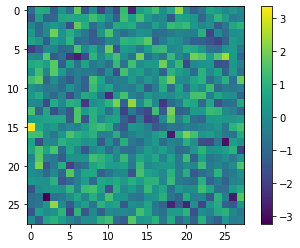

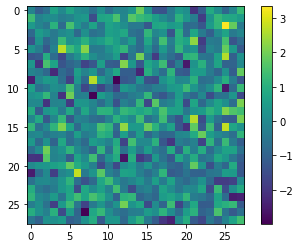

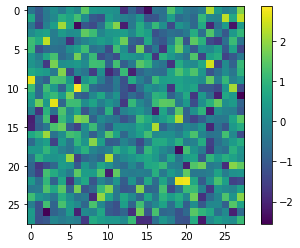

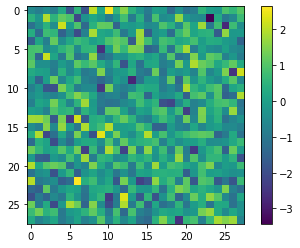

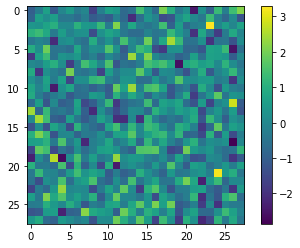

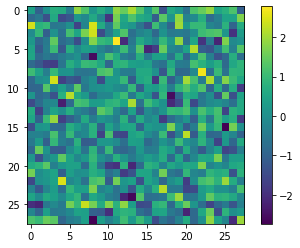

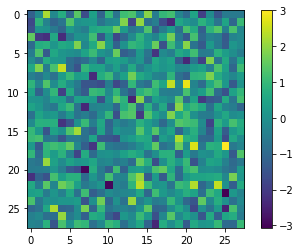

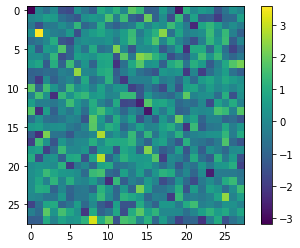

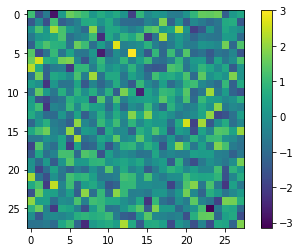

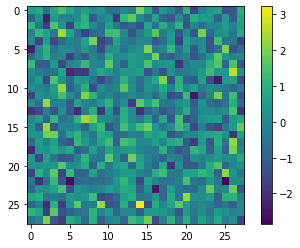

Train:

Performance: acc=0.893,
 pr=[(0.9473239912206652, 0.9365715239525956), (0.9571343814891724, 0.953739284658587), (0.8736153071500503, 0.8737619607184824), (0.8752242701027565, 0.8755098711045848), (0.8972954467648065, 0.8886251907102899), (0.8441247002398081, 0.8474074074074074), (0.909766813112538, 0.9060922248401212), (0.9109337589784517, 0.9184100418410042), (0.8381473252435481, 0.8429013406668958), (0.8626659942847538, 0.8721957851801495)],
 M=[[5611    0   33   29   12   83   80   11   48   16]
 [   0 6453   78   24   13   22   13   26  101   12]
 [  55   51 5205  120   80   27  138  103  146   33]
 [  36   28  164 5366    9  226   40   54  138   70]
 [  16   28   47    5 5242   26   92   44   75  267]
 [  96   22   60  229   73 4576   98   23  183   61]
 [  62   44   94   27   64  143 5384    7   86    7]
 [  26   34  135   44   82   19    2 5707   32  184]
 [  53   81  117  197   65  215   85   32 4904  102]
 [  36   25   24   88  259   63   10  207  105 5132]]
Test:

Per

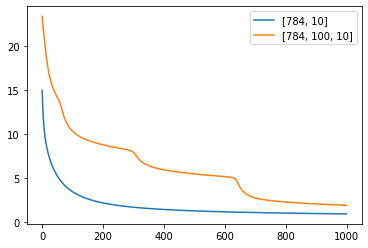

In [44]:
losses1 = train_one_model([784, 10], print_img=True)
losses2 = train_one_model([784, 100, 10])

lin = np.arange(len(losses1))
plt.plot(lin, losses1, label='[784, 10]')
plt.plot(lin, losses2, label='[784, 100, 10]')
plt.legend(loc='best')
plt.show()

Naučene matrice za svaku pojedinu znamenku imaju veće vrijednosti težina gdje bi se očekivano za tu znamenku nalazila tamna boja, te ima negativne vrijednosti uz same rubove znamenke, koji su bitni kod raspoznavanja pojedine znamenke.

Regularizacija kod dubokih modela uzrokuje pad točnosti na skupu za učenje te rast točnosti na skupu za testiranje. Još kažemo da regularizacija omogućava bolju generalizaciju, kažnjavajući modele s visokim težinama što upućuje na prenaučenost.